## **Ephys data playground**
Author: patrick.mccarthy@univ.ox.ac.uk

In [1]:
%load_ext autoreload
%autoreload 2

In [1020]:
from scipy.io import loadmat
from npixloader.align_ephysbeh import Aligner_EphysBeh
from npixloader.analysis_fns import get_ephys_all, get_ephys_all_dict, plt_ephys_all_grandavg
import npixloader as npl
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, interpolate
from copy import deepcopy
from sklearn.decomposition import PCA

In [3]:
csv_path = r"Y:\\\\Ephys\\ReportOpto_DataFrame.csv"
ephys_path = r"Z:\\\\"
beh_path = r"Z:\\\\"

Load dataset

In [4]:
# create datset object for all-experiment dataframe
dset = npl.DSetObj(path_reportopto=csv_path)

loading dataset...
filtering neuropixels recordings...


In [373]:
# dset.npix

### Load dataset

Key functions:
Aligner.EphyBeh.parse_ephys_rewechoes()
Aligner.EphyBeh.parse_beh_rewechoes()

In [7]:
# dset_ind = 10
enclosing_folder = r"Z:\\BR047\2023-12-14"

In [8]:
# exp = npl.ExpObj_ReportOpto(dset_obj=dset, dset_ind=dset_ind)  # loads expref 5 into exp
exp = npl.ExpObj_ReportOpto(enclosing_folder=enclosing_folder,
                            ephys_folder=r"ephys_g0",
                            beh_folder=r"1",
                            ) 


loading Z:\\BR047\2023-12-14...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='1'
folder='1'
loading behavior...
	loading Block and Timeline files
	parsing stim and choice properties...
	adding wheel data...
loading histology...
probe_file_name='probe_file.txt'
	making clust->ch map...
		loading cluster and channel info...
		associating clusts with chs...
	making ch->region map...
		getting HERBS probe file...
	making ch->coordinate map...
		getting HERBS probe file...
loading ephys...
	loading spike data and channel position data...
	histology alignment data...
	filtering clusters...
	extracting spiketimes...
	aligning ephys to behavior...
		aligned.
	adding spktrain...
	convolving with kernel...


plotting behavior...
	task
	adding behavior metrics...
		performance metrics
		reward metrics
		reaction metrics
		wheel turn metrics
	wheel turning
	performance metrics
	reaction metrics
plotting ephys...
	raster plot
	firing rate_clust=137...
	adding spktrain...
	convolving with kernel...
saving fig.....


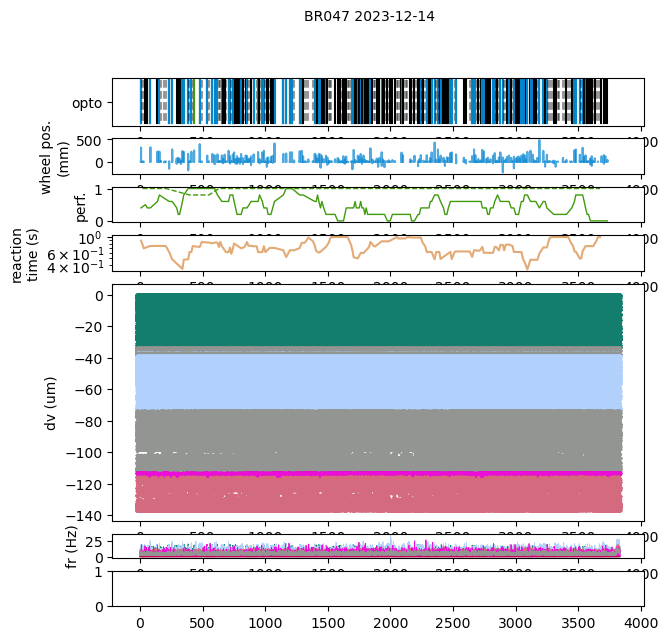

cleanup...


In [11]:
exp.plt_exp()

### Stimulus align and plot PSTHs (manually)

In [514]:
exp.beh.stim.__dict__.keys()

dict_keys(['t_start', 'opto'])

In [660]:
fs_ephys = 1/(exp.ephys.spk.t[1] - exp.ephys.spk.t[0])

In [775]:
# segment by stim
t_pre = 1000e-3
ephys_segmented = {}
for stim_idx in range(len(exp.beh.stim.t_start)-1):

    rel_idxs = np.where((np.logical_and(np.greater_equal(exp.ephys.spk.t, exp.beh.stim.t_start[stim_idx]- t_pre),
                                            np.less_equal(exp.ephys.spk.t, exp.beh.stim.t_start[stim_idx+1]-t_pre))))[0]

    spikes_this_stim = np.empty(shape=(len(exp.ephys.spk.train), len(rel_idxs)))
    for neuron_id in range(len(exp.ephys.spk.train)):
        spikes_this_stim[neuron_id, :] = exp.ephys.spk.train[neuron_id][rel_idxs]

    ephys_segmented[stim_idx] = {"spikes": deepcopy(spikes_this_stim),
                                 "opto": exp.beh.stim.opto[stim_idx]}


In [776]:
trial_lengths = [len(ephys_segmented[trial_id]["spikes"][1]) for trial_id in range(len(ephys_segmented))]
num_neurons = len(ephys_segmented[0]["spikes"])

Inspect inter-stimulation intervals

In [777]:
counts, bin_edges = np.histogram(trial_lengths / fs_ephys)
bin_centres = [(bin_edges[idx] + bin_edges[idx+1])/2 for idx in range(len(counts))]

Text(0, 0.5, 'number of trials')

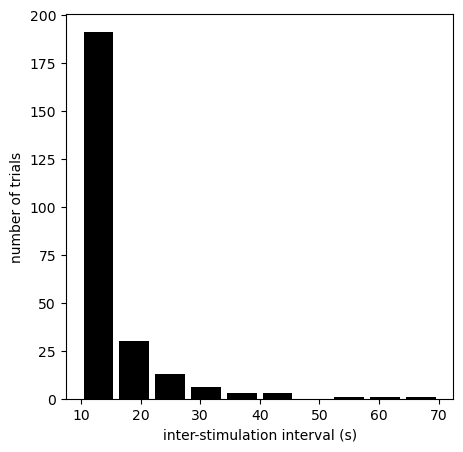

In [778]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(bin_centres, counts, width=5, facecolor="k")
ax.set_xlabel("inter-stimulation interval (s)")
ax.set_ylabel("number of trials")

In [779]:
trial_lengths / fs_ephys

array([10.67, 10.46, 13.88, 15.43, 24.24, 56.84, 15.58, 11.54, 28.27,
       11.26, 26.75, 24.55, 35.46, 11.89, 11.03, 11.67, 11.85, 10.24,
       35.28, 10.06, 15.62,  9.92, 11.34, 45.13, 15.79, 43.72, 13.64,
       27.24, 18.38, 22.39, 11.93, 11.39, 11.88, 10.63, 11.4 , 11.27,
       20.97, 11.2 ,  9.97, 12.12, 10.72, 11.45, 11.74, 10.22, 11.83,
       10.43, 14.66, 11.05, 10.78, 11.25, 10.04, 10.64, 11.06, 20.69,
       24.37, 11.41, 11.27, 11.88, 10.61, 12.58, 11.62, 11.43, 10.36,
       11.09, 11.07, 14.42, 14.75, 70.03, 23.11, 29.81, 16.75, 16.56,
       44.33, 16.55, 10.9 , 10.19, 12.14, 19.31, 36.24, 14.82, 11.63,
       10.44, 11.35, 12.75, 11.01, 14.07, 18.51, 11.38, 12.05, 10.23,
       11.19, 27.06, 21.88, 11.49, 10.9 , 12.55, 10.9 , 10.94, 11.18,
       11.27, 11.25, 16.07, 11.08, 10.3 , 10.69, 10.36, 12.1 , 10.88,
       11.41, 10.51, 12.15, 10.48, 10.51, 12.  , 10.84, 11.5 , 15.71,
       11.96, 11.38, 10.9 , 11.51, 10.24, 17.93, 10.75, 11.36, 10.75,
       12.18, 11.48,

In [780]:
np.where(trial_lengths / fs_ephys == 70.03)

(array([67]),)

In [781]:
exp.beh.stim.t_start[67]

np.float64(1073.701)

Text(0.5, 0, 'time (s)')

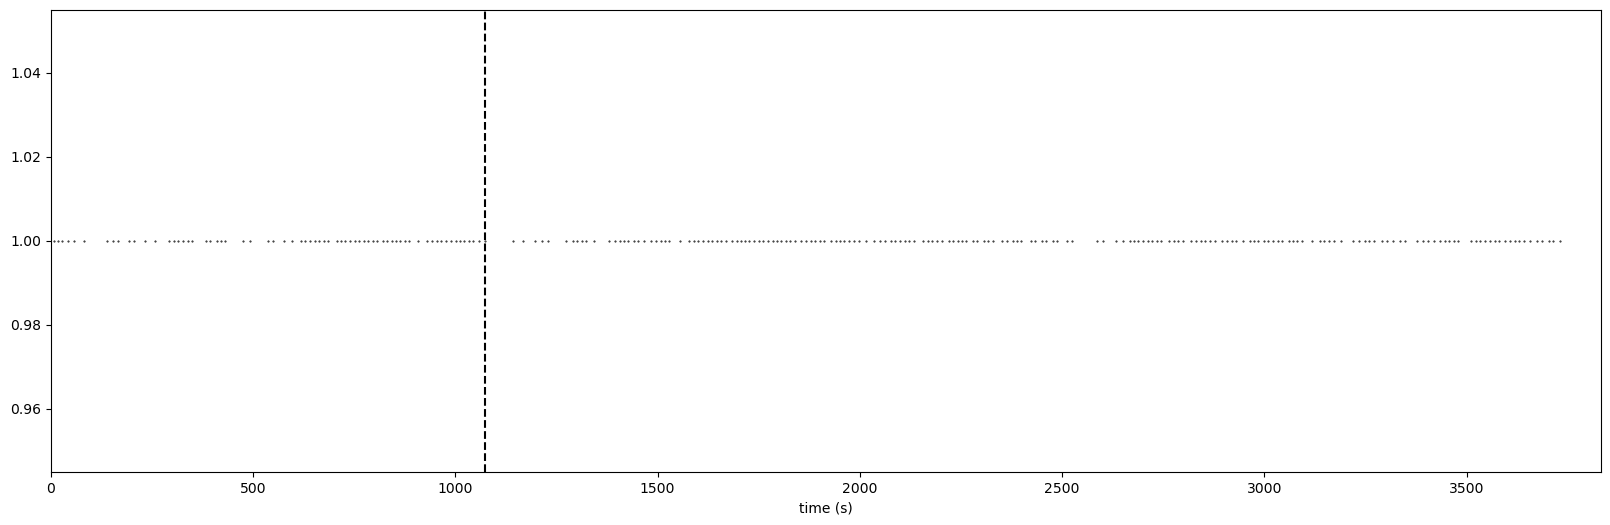

In [782]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.scatter(exp.beh.stim.t_start, np.ones(len(exp.beh.stim.t_start)), s=0.2, c="k")
ax.axvline(exp.beh.stim.t_start[67], c="k", ls="--")
ax.set_xlim(0, exp.ephys.spk.t[-1])
ax.set_xlabel(("time (s)"))


In [818]:
counts, bin_edges = np.histogram(trial_lengths / fs_ephys)
bin_centres = [(bin_edges[idx] + bin_edges[idx+1])/2 for idx in range(len(counts))]

Text(0, 0.5, 'number of trials')

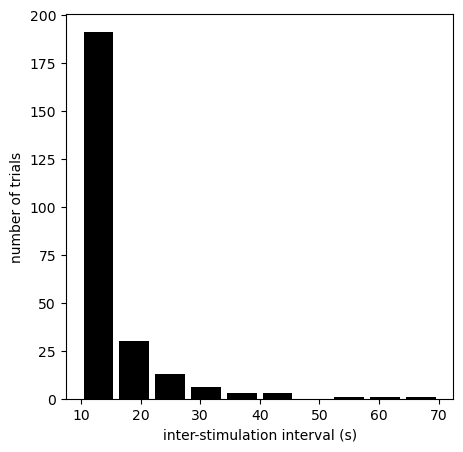

In [819]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.bar(bin_centres, counts, width=5, facecolor="k")
ax.set_xlabel("inter-stimulation interval (s)")
ax.set_ylabel("number of trials")

In [820]:
# TODO: implement padding to common length to support unevenly spaced trials
ephys_stim_separated = {"stim": [], "null": []}
spikes_summed = {"stim":  [np.zeros(np.max(trial_lengths)) for _ in range(num_neurons)],
                 "null":  [np.zeros(np.max(trial_lengths)) for _ in range(num_neurons)]}
num_trials_summing = {"stim":  np.zeros(np.max(trial_lengths)),
                      "null":  np.zeros(np.max(trial_lengths))}
spikes_averaged = {"stim":  [np.zeros(np.max(trial_lengths)) for _ in range(num_neurons)],
                 "null":  [np.zeros(np.max(trial_lengths)) for _ in range(num_neurons)]}
for stim_id in range(len(ephys_segmented)):

    pad_width = np.max(trial_lengths) - trial_lengths[stim_id]
    num_trials_trace = np.concatenate([np.ones(trial_lengths[stim_id]), np.zeros(pad_width)])

    if ephys_segmented[stim_id]["opto"]:
        ephys_stim_separated["stim"].append(ephys_segmented[stim_id])

        num_trials_summing["stim"] += num_trials_trace

        for neuron_id in range(len(ephys_segmented[stim_id]["spikes"])):
            spikes_padded = np.pad(ephys_segmented[stim_id]["spikes"][neuron_id], pad_width=(0, pad_width), constant_values=0)
            spikes_summed["stim"][neuron_id] += spikes_padded
    else:
        num_trials_summing["null"] += num_trials_trace

        ephys_stim_separated["null"].append(ephys_segmented[stim_id])
        for neuron_id in range(len(ephys_segmented[stim_id]["spikes"])):
            spikes_padded = np.pad(ephys_segmented[stim_id]["spikes"][neuron_id], pad_width=(0, pad_width), constant_values=0)
            spikes_summed["null"][neuron_id] += spikes_padded

for neuron_id in range(len(ephys_segmented[stim_id]["spikes"])):
    for stim_type in ["null", "stim"]: 
         spikes_averaged[stim_type][neuron_id] = spikes_summed[stim_type][neuron_id] / num_trials_summing[stim_type]

C:\Users\Lak Lab\AppData\Local\Temp\ipykernel_13348\1650811861.py:32: RuntimeWarning: invalid value encountered in divide
  spikes_averaged[stim_type][neuron_id] = spikes_summed[stim_type][neuron_id] / num_trials_summing[stim_type]


In [821]:
# params for histograms
bin_size = 200e-3
num_bins = np.floor(bin_size * fs_ephys)

Text(0.5, 1.0, 'PSTH for neuron 2, null stim 1, bin width = 0.2 s')

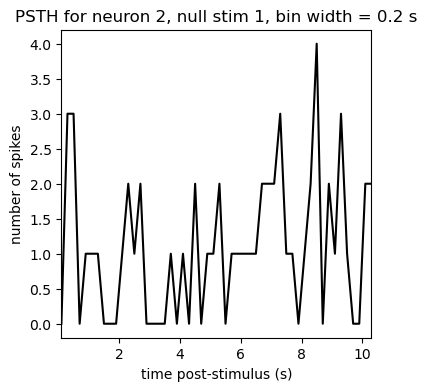

In [822]:
# histogram for individual trial
neuron_id = 2
stim_id = 1
stim_type ="null"

spike_times = np.where(ephys_stim_separated[stim_type][stim_id]["spikes"][neuron_id] == 1) / fs_ephys
# compute PSTH for this neuron and stim ID
psth, bin_edges = np.histogram(spike_times, 
                    bins=np.arange(0, len(ephys_segmented[stim_id]["spikes"][neuron_id]) / fs_ephys, bin_size))

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
bin_centres = bin_edges[:-1] + bin_size/2
ax.plot(bin_centres, psth, c="k")
ax.set_xlim(bin_centres[0], bin_centres[-1])
ax.set_xlabel("time post-stimulus (s)")
ax.set_ylabel("number of spikes")
ax.set_title(f"PSTH for neuron {neuron_id}, {stim_type} stim {stim_id}, bin width = {bin_size} s")

In [823]:
# # histogram for individual trial
# for neuron_id in range(10, 20):
#     fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#     t_ax = np.arange(0, len(spikes_averaged["null"][neuron_id])) / (fs_ephys)

#     ax.plot(t_ax - t_pre, spikes_averaged["null"][neuron_id], label="no opto", c="r")
#     ax.plot(t_ax - t_pre, spikes_averaged["stim"][neuron_id], label="opto", c="b")

#     ax.set_xlabel("time post-stimulus (s)")
#     ax.set_ylabel("avg number of spikes")
#     ax.set_title(f"PSTH for neuron {neuron_id}, trial-averaged")
#     ax.set_xlim(-t_pre, 2)
#     ax.axvline(0, label="onset", c="k", ls="--")
#     # ax.set_ylim(0, 0.25)
#     ax.legend()

In [ ]:
def bin_spike_data(avg_spikes, bin_width, sampling_freq_hz):
    samples_per_bin = int((bin_width) * sampling_freq_hz)
    n_bins = len(avg_spikes) // samples_per_bin
    binned_spikes = avg_spikes[:n_bins * samples_per_bin].reshape(n_bins, samples_per_bin).sum(axis=1)
    return binned_spikes

In [835]:
bin_size

0.2

In [863]:
# kernel_size = int(bin_size * fs_ephys)
kernel_size = int(0.05 * fs_ephys)
kernel = np.ones(kernel_size)

In [864]:
kernel_size

5

In [865]:
spikes_avg_binned = {"null": [], "stim": []}
spikes_avg_convbinned = {"null": [], "stim": []}
for stim_type in ["null", "stim"]:
    for neuron_id in range(len(spikes_summed[stim_type])):
        spikes_binned = bin_spike_data(spikes_averaged[stim_type][neuron_id], bin_width=bin_size, sampling_freq_hz=fs_ephys)
        spikes_convbinned = np.convolve(spikes_averaged[stim_type][neuron_id], kernel, mode="same")
        # print(f"{len(spikes_averaged[stim_type][neuron_id])=},    {len(spikes_convbinned)}")
        spikes_avg_binned[stim_type].append(spikes_binned)
        spikes_avg_convbinned[stim_type].append(spikes_convbinned)

In [866]:
t_ax_original = np.arange(0, np.max(trial_lengths)) / fs_ephys
t_ax_new = np.linspace(0, t_ax_original[-1], len(spikes_avg_binned["null"][0]))

In [867]:
len(spikes_avg_binned["null"][0])

350

In [868]:
t_ax_original

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 7.000e+01, 7.001e+01,
       7.002e+01], shape=(7003,))

In [869]:
t_ax_new

array([ 0.        ,  0.20063037,  0.40126074,  0.60189112,  0.80252149,
        1.00315186,  1.20378223,  1.40441261,  1.60504298,  1.80567335,
        2.00630372,  2.2069341 ,  2.40756447,  2.60819484,  2.80882521,
        3.00945559,  3.21008596,  3.41071633,  3.6113467 ,  3.81197708,
        4.01260745,  4.21323782,  4.41386819,  4.61449857,  4.81512894,
        5.01575931,  5.21638968,  5.41702006,  5.61765043,  5.8182808 ,
        6.01891117,  6.21954155,  6.42017192,  6.62080229,  6.82143266,
        7.02206304,  7.22269341,  7.42332378,  7.62395415,  7.82458453,
        8.0252149 ,  8.22584527,  8.42647564,  8.62710602,  8.82773639,
        9.02836676,  9.22899713,  9.42962751,  9.63025788,  9.83088825,
       10.03151862, 10.232149  , 10.43277937, 10.63340974, 10.83404011,
       11.03467049, 11.23530086, 11.43593123, 11.6365616 , 11.83719198,
       12.03782235, 12.23845272, 12.43908309, 12.63971347, 12.84034384,
       13.04097421, 13.24160458, 13.44223496, 13.64286533, 13.84

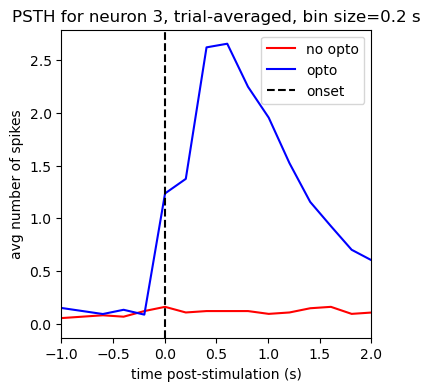

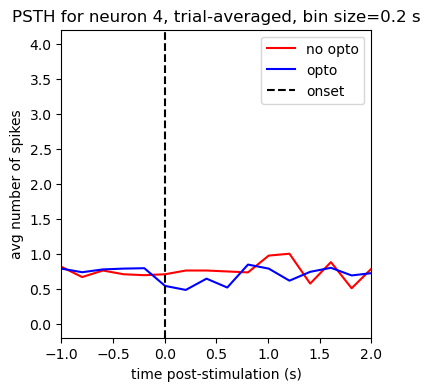

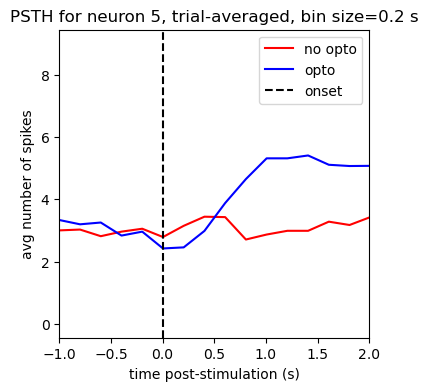

In [870]:
# histogram for individual trial
for neuron_id in range(3, 6):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(t_ax_new - t_pre, spikes_avg_binned["null"][neuron_id], label="no opto", c="r")
    ax.plot(t_ax_new - t_pre, spikes_avg_binned["stim"][neuron_id], label="opto", c="b")

    ax.set_xlabel("time post-stimulation (s)")
    ax.set_ylabel("avg number of spikes")
    ax.set_title(f"PSTH for neuron {neuron_id}, trial-averaged, bin size={bin_size} s")
    ax.set_xlim(-t_pre, 2)
    ax.axvline(0, label="onset", c="k", ls="--")
    ax.legend()

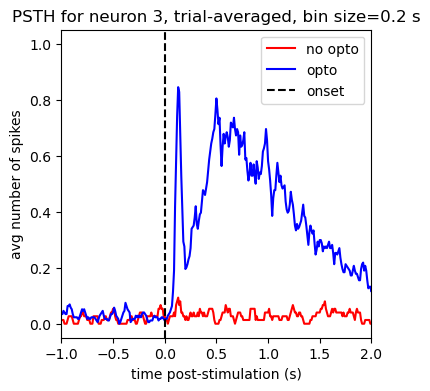

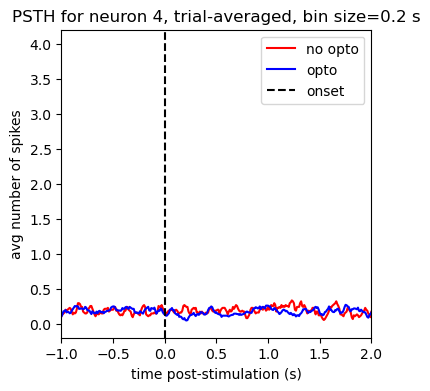

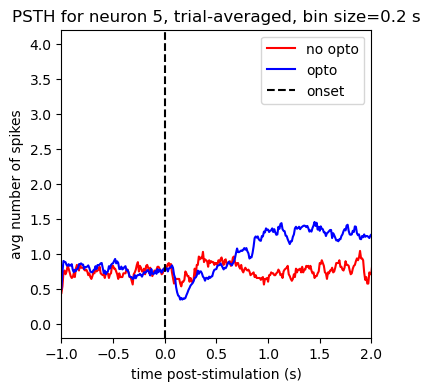

In [871]:
# histogram for individual trial
for neuron_id in range(3, 6):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(t_ax_original - t_pre, spikes_avg_convbinned["null"][neuron_id], label="no opto", c="r")
    ax.plot(t_ax_original - t_pre, spikes_avg_convbinned["stim"][neuron_id], label="opto", c="b")

    ax.set_xlabel("time post-stimulation (s)")
    ax.set_ylabel("avg number of spikes")
    ax.set_title(f"PSTH for neuron {neuron_id}, trial-averaged, bin size={bin_size} s")
    ax.set_xlim(-t_pre, 2)
    ax.axvline(0, label="onset", c="k", ls="--")
    ax.legend()

In [872]:
# plot responses averaged over all neurons
null_response_zscored = stats.zscore(np.array(spikes_avg_binned["null"]), axis=0)
null_response_mean = np.mean(np.array(spikes_avg_binned["null"]), axis=0)
null_response_median = np.median(np.array(spikes_avg_binned["null"]), axis=0)
null_response_sem = stats.sem(np.array(spikes_avg_binned["null"]), axis=0)

stim_response_zscored = stats.zscore(np.array(spikes_avg_binned["stim"]), axis=0)
stim_response_mean = np.mean(np.array(spikes_avg_binned["stim"]), axis=0)
stim_response_median = np.median(np.array(spikes_avg_binned["stim"]), axis=0)
stim_response_sem = stats.sem(np.array(spikes_avg_binned["stim"]), axis=0)

In [873]:
# plot responses averaged over all neurons
null_response_conv_zscored = stats.zscore(np.array(spikes_avg_convbinned["null"]), axis=0)
null_response_conv_mean = np.mean(np.array(spikes_avg_convbinned["null"]), axis=0)
null_response_conv_median = np.median(np.array(spikes_avg_convbinned["null"]), axis=0)
null_response_conv_sem = stats.sem(np.array(spikes_avg_convbinned["null"]), axis=0)

stim_response_conv_zscored = stats.zscore(np.array(spikes_avg_convbinned["stim"]), axis=0)
stim_response_conv_mean = np.mean(np.array(spikes_avg_convbinned["stim"]), axis=0)
stim_response_conv_median = np.median(np.array(spikes_avg_convbinned["stim"]), axis=0)
stim_response_conv_sem = stats.sem(np.array(spikes_avg_convbinned["stim"]), axis=0)

In [879]:
# Z-scored responses
null_response_conv_zscored = stats.zscore(np.array(spikes_avg_convbinned["null"]), axis=0)
stim_response_conv_zscored = stats.zscore(np.array(spikes_avg_convbinned["stim"]), axis=0)

# Stats on z-scored responses (averaged across neurons)
null_conv_zscored_mean = np.mean(null_response_conv_zscored, axis=0)
null_conv_zscored_median = np.median(null_response_conv_zscored, axis=0)
null_conv_zscored_sem = stats.sem(null_response_conv_zscored, axis=0)

stim_conv_zscored_mean = np.mean(stim_response_conv_zscored, axis=0)
stim_conv_zscored_median = np.median(stim_response_conv_zscored, axis=0)
stim_conv_zscored_sem = stats.sem(stim_response_conv_zscored, axis=0)

In [874]:
null_response_zscored.shape

(138, 350)

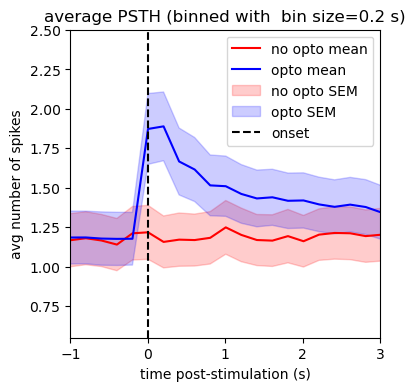

In [875]:
# histogram for individual trial
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(t_ax_new-t_pre, null_response_mean, label="no opto mean", c="r")
ax.plot(t_ax_new-t_pre, stim_response_mean, label="opto mean", c="b")
ax.fill_between(t_ax_new-t_pre, null_response_mean-null_response_sem, null_response_mean+null_response_sem, color="r", label="no opto SEM", alpha=0.2)
ax.fill_between(t_ax_new-t_pre, stim_response_mean-stim_response_sem, stim_response_mean+stim_response_sem, color="b", label="opto SEM", alpha=0.2)

ax.set_xlabel("time post-stimulation (s)")
ax.set_ylabel("avg number of spikes")
ax.set_title(f"average PSTH (binned with  bin size={bin_size} s)")
ax.set_xlim(-t_pre, 3)
ax.axvline(0, label="onset", c="k", ls="--")

ax.legend()

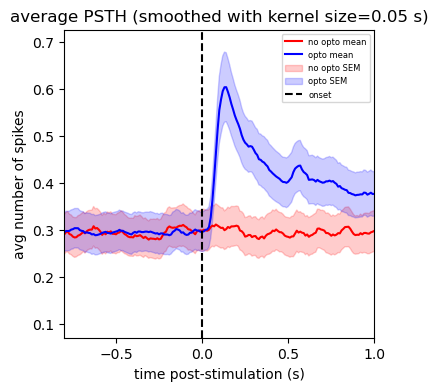

In [878]:
# histogram for individual trial
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(t_ax_original-t_pre, null_response_conv_mean, label="no opto mean", c="r")
ax.plot(t_ax_original-t_pre, stim_response_conv_mean, label="opto mean", c="b")
ax.fill_between(t_ax_original-t_pre, null_response_conv_mean-null_response_conv_sem, null_response_conv_mean+null_response_conv_sem, color="r", label="no opto SEM", alpha=0.2)
ax.fill_between(t_ax_original-t_pre, stim_response_conv_mean-stim_response_conv_sem, stim_response_conv_mean+stim_response_conv_sem, color="b", label="opto SEM", alpha=0.2)

ax.set_xlabel("time post-stimulation (s)")
ax.set_ylabel("avg number of spikes")
ax.set_title(f"average PSTH (smoothed with kernel size={kernel_size/fs_ephys} s)")
ax.set_xlim(-t_pre+0.2, 1)
ax.axvline(0, label="onset", c="k", ls="--")

ax.legend(fontsize=6)

### Stimulus align and plot PSTHs (using NPIX loader)

In [444]:
exp.get_aligned_ephys(region='supplemental somatosensory')

aligning ephys to behavior...
	adding spktrain...
	convolving with kernel...
	adding behavior metrics...
		performance metrics
		reward metrics
		reaction metrics
		wheel turn metrics
	extracting area supplemental somatosensory...


namespace(opto=namespace(corr={'supplemental somatosensory': array([[[ 0.24454447,  0.29395603,  0.29395603, ...,  0.30495748,
                                         0.31420135,  0.28102767],
                                       [-0.80763535, -0.89555283, -0.97461861, ...,  1.91388661,
                                         1.76892683,  1.61044432],
                                       [-0.54596758, -0.41318263, -0.2454579 , ...,  7.73418802,
                                         7.5174997 ,  7.12260124],
                                       ...,
                                       [-0.42744482, -0.42744482, -0.42744482, ..., -0.40239191,
                                        -0.38179545, -0.34752773],
                                       [ 0.45763157,  0.33213197,  0.2233861 , ..., -0.56990144,
                                        -0.5456785 , -0.47419517],
                                       [-1.02010667, -1.02010667, -1.02010667, ..., -1.01743259,
         

aligning ephys to behavior...
	adding spktrain...
	convolving with kernel...
	adding behavior metrics...
		performance metrics
		reward metrics
		reaction metrics
		wheel turn metrics
	extracting area supplemental somatosensory...


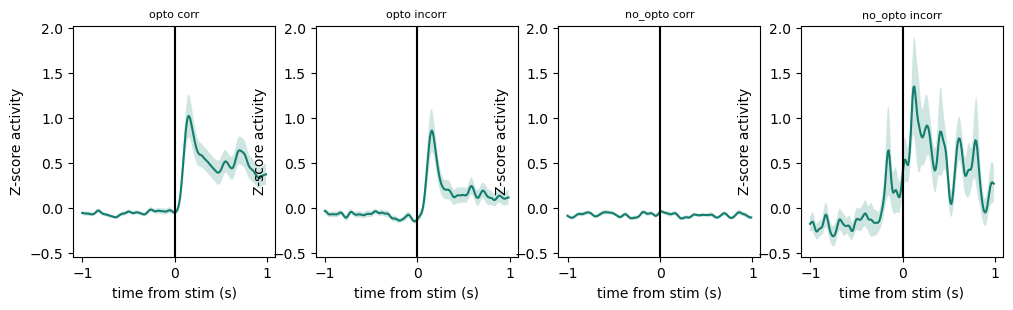

In [445]:
exp.plt_aligned_ephys(region=['supplemental somatosensory'], figsize=(12, 3))

Load entire dataset using NPIXLOADER

In [885]:
region = "supplemental somatosensory"

In [962]:
ephys_all = get_ephys_all(dset=dset, region=region)

--------------
loading Z:\BR044\2023-12-06...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='3'
folder='3'
!! could not load expref  QNAP-AL001.dpag.ox.ac.uk\BR044\2023-12-06\3!! 
error: [WinError 3] The system cannot find the path specified: '3'
--------------
loading Z:\BR044\2023-12-07...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='3'
folder='3'
!! could not load expref  QNAP-AL001.dpag.ox.ac.uk\BR044\2023-12-07\3!! 
error: [WinError 3] The system cannot find the path specified: '3'
--------------
loading Z:\BR044\2023-12-08...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='1'
folder='1'
loading behavior...
	loading Block and Timeline files


c:\Users\Lak Lab\Documents\BehNPix_ExpLoader\npixloader\analysis_fns.py:1008: SyntaxWarning: invalid escape sequence '\D'
  ax_corr_perf_vs_react_t.set_xlabel('$\Delta$frac. session')


KeyboardInterrupt: 

In [963]:
ephys_all_dict = get_ephys_all(dset=dset)

--------------
loading Z:\BR044\2023-12-06...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='3'
folder='3'
!! could not load expref  QNAP-AL001.dpag.ox.ac.uk\BR044\2023-12-06\3!! 
error: [WinError 3] The system cannot find the path specified: '3'
--------------
loading Z:\BR044\2023-12-07...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='3'
folder='3'
!! could not load expref  QNAP-AL001.dpag.ox.ac.uk\BR044\2023-12-07\3!! 
error: [WinError 3] The system cannot find the path specified: '3'
--------------
loading Z:\BR044\2023-12-08...
	creating aligner object...
self.folder.ephys='ephys_g0', self.folder.beh='1'
folder='1'
loading behavior...
	loading Block and Timeline files
	parsing stim and choice properties...
	adding wheel data...
loading histology...
probe_file_name='probe_file.txt'
	making clust->ch map...
		loading cluster and channel info...
		associating clusts with chs...
	making ch->region map...
		getting HERBS probe fi

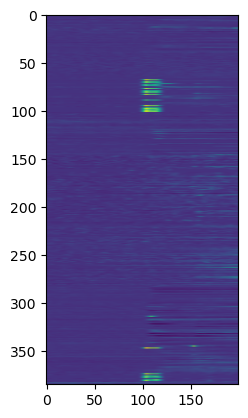

In [953]:
plt.imshow(ephys_all.avg.opto.corr)

In [971]:
# dims of any tr object: [neuron_id][session_id, time_id]

In [956]:
ephys_all.tr.no_opto.corr.shape

(385,)

Reduce using PCA and cluster according to task conditions

In [1051]:
task_conditions = ["opto", "no_opto"]
choice_conditions = ["corr", "incorr"]

In [1080]:
# pool data across task and choice conditions, neurons and sessions
ephys_pooled = []
task_conds = []
choice_conds = []
neuron_ids = []
for task_cond in task_conditions:
    for choice_cond in choice_conditions:
        data = getattr(getattr(ephys_all.tr, task_cond), choice_cond)
        for neuron_id in range(data.shape[0]):
            ephys_pooled_this_neuron = []
            for session_id in range(data[neuron_id].shape[0]):
                ephys_pooled.append(data[neuron_id][session_id, :])
                neuron_ids.append(neuron_id)
                task_conds.append(task_cond)
                choice_conds.append(choice_cond)
ephys_pooled = np.array(ephys_pooled)

unique_task_conds = sorted(set(task_conds))
unique_choice_conds = sorted(set(choice_conds))

task_cond_to_int = {label: idx for idx, label in enumerate(unique_task_conds)}
choice_cond_to_int = {label: idx for idx, label in enumerate(unique_choice_conds)}

# Convert list of labels to list of integers
task_conds_encoded = np.array([task_cond_to_int[label] for label in task_conds])
choice_conds_encoded = np.array([choice_cond_to_int[label] for label in choice_conds])
neuron_ids = np.array(neuron_ids)

In [1096]:
# perform PCA on pooled data
pca = PCA(n_components=100)
ephys_reduced = pca.fit_transform(ephys_pooled)

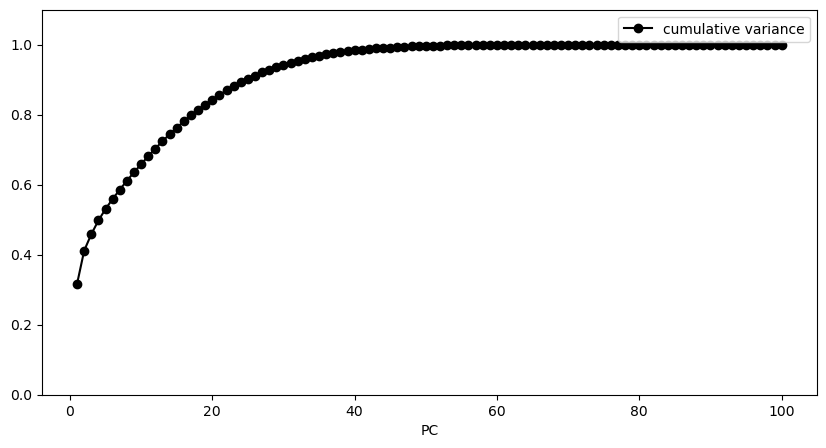

In [1105]:
# scree plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), 'o-', label='cumulative variance', c="k")
ax.set_xlabel("PC")
ax.set_ylim(0, 1.1)
ax.legend()


rel_idxs=(array([56735, 56736, 56737, ..., 88187, 88188, 88189], shape=(31455,)),)
rel_idxs=(array([    0,     1,     2, ..., 56732, 56733, 56734], shape=(56735,)),)


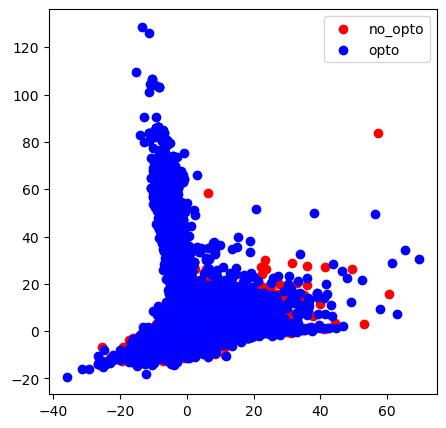

In [1091]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colours = ["r", "b"]
for cond_idx, (label, cond_value) in enumerate(task_cond_to_int.items()):
    rel_idxs = np.where(task_conds_encoded == cond_value)
    print(f"{rel_idxs=}")
    ax.scatter(ephys_reduced[rel_idxs, 1], ephys_reduced[rel_idxs, 0], c=colours[cond_idx], label=label)
ax.legend()


rel_idxs=(array([    0,     1,     2, ..., 84283, 84284, 84285], shape=(50965,)),)
rel_idxs=(array([23414, 23415, 23416, ..., 88187, 88188, 88189], shape=(37225,)),)


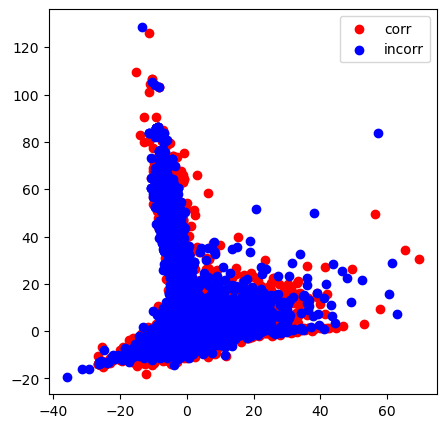

In [1092]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colours = ["r", "b"]
for cond_idx, (label, cond_value) in enumerate(choice_cond_to_int.items()):
    rel_idxs = np.where(choice_conds_encoded == cond_value)
    print(f"{rel_idxs=}")
    ax.scatter(ephys_reduced[rel_idxs, 1], ephys_reduced[rel_idxs, 0], c=colours[cond_idx], label=label)
ax.legend()


C:\Users\Lak Lab\AppData\Local\Temp\ipykernel_13348\167690457.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


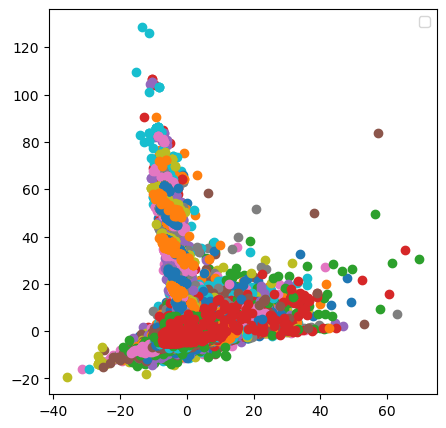

In [1094]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for neuron_id in range(384):
    rel_idxs = np.where(neuron_ids == neuron_id)
    ax.scatter(ephys_reduced[rel_idxs, 1], ephys_reduced[rel_idxs, 0])
ax.legend()


TODO: load raw ephys